In [2051]:
# importing libraries
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import geopandas
import geoplot
from shapely.geometry import Polygon, Point
import numpy as np
from scipy import stats
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import geoplot.crs as gcrs

# define path and variables

In [1881]:
path = 'C:/Users/Zaca/Documents/Datasets/nyc/'

# defining functions

In [1882]:
pcints = geopandas.read_file(path + 'nypd_precincts.shp').to_crs(epsg=4326)
pcints['pct'] = pcints['pct'].astype('int32')

clean_map = geopandas.GeoDataFrame()
clean_map['precinct'] = pcints['pct'].unique()
clean_map['geometry'] = [Polygon(max(pcints.loc[pcints['pct'] == pct, 'geometry'].unary_union, key=lambda a: a.area).exterior) if pcints.loc[pcints['pct'] == pct, 'geometry'].unary_union.geom_type == 'MultiPolygon' else Polygon(pcints.loc[pcints['pct'] == pct, 'geometry'].unary_union.exterior) for pct in clean_map.precinct]

In [1883]:
crime = pd.read_csv(path + 'nypd_historic_07-18.csv', index_col=0)

C:\Users\Zaca\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


# select type of crime we are analyzing

In [1995]:
desc = 'BURGLARY'
ds = crime[crime.description == desc]
ds.groupby('precinct').count()

,date,time,class_code,description,level,borough,premises,latitude,longitude
precinct,,,,,,,,,
1,1849,1849,1849,1849,1849,1849,1849,1849,1849
5,1374,1374,1374,1374,1374,1374,1374,1374,1374
6,2034,2034,2034,2034,2034,2034,2034,2034,2034
7,992,992,992,992,992,992,992,992,992
9,2167,2167,2167,2167,2167,2167,2167,2167,2167
...,...,...,...,...,...,...,...,...,...
115,3589,3589,3589,3589,3589,3589,3589,3589,3589
120,3241,3241,3241,3241,3241,3241,3241,3241,3241
121,747,747,747,747,747,747,747,747,747


In [1996]:
# transform to datetime
ds['date'] = pd.to_datetime(ds['date'])

C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# space and time selection

In [2060]:
start_date = '2017-08-01'
end_date = '2017-12-31'
precinct = 75
n_clusters = 6

In [2034]:
subselection = ds[(ds.date > start_date) & (ds.date < end_date) & (ds.precinct == precinct)]

In [2035]:
def make_clusters(data, nclusters):
    
    data = data[['latitude', 'longitude', 'time']]
    stdscaler = StandardScaler()
    features = stdscaler.fit_transform(data)
    #cluster = KMeans(n_clusters)
    cluster = AgglomerativeClustering(n_clusters)
    model = cluster.fit(features)
    
    return model.labels_

In [2011]:
subselection['k_clusters'] = make_clusters(subselection, 4)

C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [2061]:
subselection.k_clusters.value_counts().reset_index()

AttributeError: 'DataFrame' object has no attribute 'k_clusters'

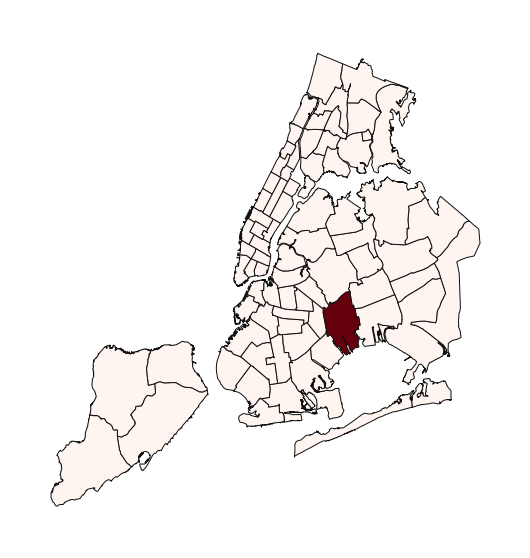

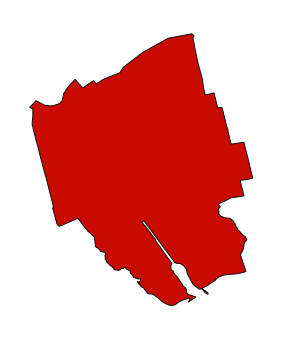

In [2058]:
def precinct_selected(precinct, basemap):
    
    basemap['selected'] = np.where(basemap.precinct == precinct, 1, 0)
    
    ax = geoplot.choropleth(basemap, hue='selected', figsize=(10, 10), lw= 1, edgecolor='k', alpha=1, cmap='Reds', projection=gcrs.AlbersEqualArea())
    ax.scatter(subselection['longitude'], subselection['latitude'], alpha=.9, cmap='viridis', s=10, color='white')
    
    geoplot.polyplot(basemap[basemap.precinct == precinct], lw=1, facecolor= 'r', edgecolor='k', alpha=1)

precinct_selected(precinct, clean_map)

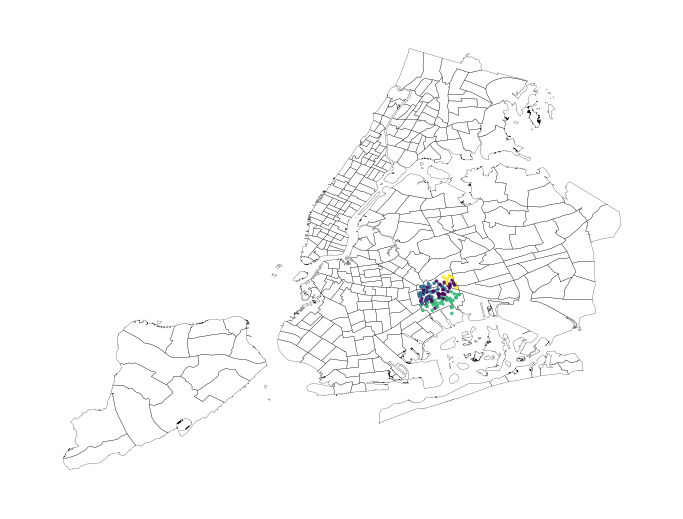

In [2015]:
subselection.groupby('k_clusters').count()

,date,time,precinct,class_code,description,level,borough,premises,latitude,longitude
k_clusters,,,,,,,,,,
0,39,39,39,39,39,39,39,39,39,39
1,46,46,46,46,46,46,46,46,46,46
2,44,44,44,44,44,44,44,44,44,44
3,10,10,10,10,10,10,10,10,10,10


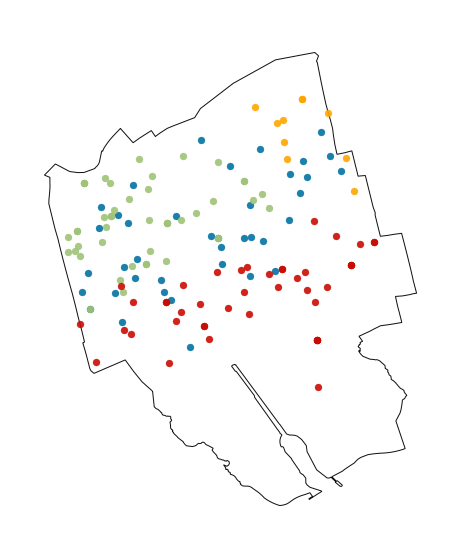

In [2016]:
ax = geoplot.polyplot(clean_map[clean_map.precinct == precinct], figsize=(10, 10), lw= 1, facecolor= 'none', edgecolor='k', alpha=1)

ax.scatter(subselection[subselection['k_clusters'] == 0]['longitude'], subselection[subselection['k_clusters'] == 0]['latitude'], c='b', alpha=.9)
ax.scatter(subselection[subselection['k_clusters'] == 1]['longitude'], subselection[subselection['k_clusters'] == 1]['latitude'], c='g', alpha=.9)
ax.scatter(subselection[subselection['k_clusters'] == 2]['longitude'], subselection[subselection['k_clusters'] == 2]['latitude'], c='r', alpha=.9)
ax.scatter(subselection[subselection['k_clusters'] == 3]['longitude'], subselection[subselection['k_clusters'] == 3]['latitude'], c='orange', alpha=.9);

In [2036]:
sns.kdeplot(subselection[subselection.k_clusters == 0].time, bw=1, color='b', label='0')
sns.kdeplot(subselection[subselection.k_clusters == 1].time, bw=1, color='g', label='1')
sns.kdeplot(subselection[subselection.k_clusters == 2].time, bw=1, color='r', label='2')
sns.kdeplot(subselection[subselection.k_clusters == 3].time, bw=1, color='orange', label='3')

plt.xlim(0, 24)

AttributeError: 'DataFrame' object has no attribute 'k_clusters'

In [2018]:
def make_contour(longitude, latitude, precinct_polygon, colors, levels):
    
    x = longitude
    y = latitude
    
    # check bounds
    xmin = precinct_polygon.bounds['minx'].values
    xmax = precinct_polygon.bounds['maxx'].values
    ymin = precinct_polygon.bounds['miny'].values
    ymax = precinct_polygon.bounds['maxy'].values
    
    # Create meshgrid
    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([x, y])
    kernel = stats.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)

    cset = ax.contour(xx, yy, f, colors=colors, levels=levels)
    
    return cset


def get_level(contour, n):
    
    # the n gives you the level
    # just remember that its backwards
    # the outermost level is 0
    
    x = []
    y = []
    for j in range(len(contour.allsegs)):
        for ii, seg in enumerate(contour.allsegs[j]):
            x += [seg[:,0]]
            y += [seg[:,1]]
    
    return list(zip(x[n], y[n]))  


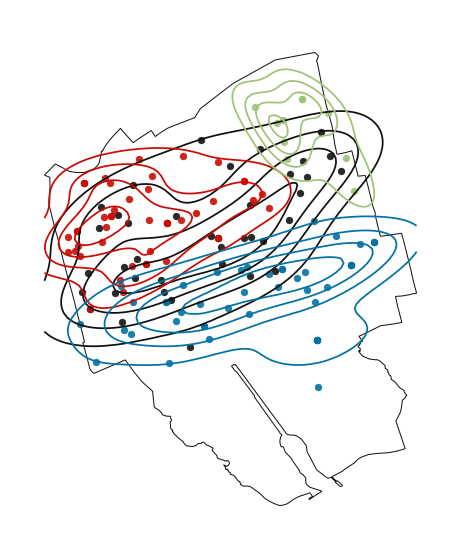

In [2020]:
ax = geoplot.polyplot(clean_map[clean_map.precinct == precinct], figsize=(10, 10), lw= 1, facecolor= 'none', edgecolor='k', alpha=1)

c0 = make_contour(subselection[subselection['k_clusters'] == 0]['longitude'], subselection[subselection['k_clusters'] == 0]['latitude'], clean_map[clean_map.precinct == precinct]['geometry'], colors='k', levels=4)
ax.scatter(subselection[subselection['k_clusters'] == 0]['longitude'], subselection[subselection['k_clusters'] == 0]['latitude'], c='k', alpha=.9)

c1 = make_contour(subselection[subselection['k_clusters'] == 1]['longitude'], subselection[subselection['k_clusters'] == 1]['latitude'], clean_map[clean_map.precinct == precinct]['geometry'], colors='r', levels=4)
ax.scatter(subselection[subselection['k_clusters'] == 1]['longitude'], subselection[subselection['k_clusters'] == 1]['latitude'], c='r', alpha=.9)

c2 = make_contour(subselection[subselection['k_clusters'] == 2]['longitude'], subselection[subselection['k_clusters'] == 2]['latitude'], clean_map[clean_map.precinct == precinct]['geometry'], colors='b', levels=4)
ax.scatter(subselection[subselection['k_clusters'] == 2]['longitude'], subselection[subselection['k_clusters'] == 2]['latitude'], c='b', alpha=.9)

c3 = make_contour(subselection[subselection['k_clusters'] == 3]['longitude'], subselection[subselection['k_clusters'] == 3]['latitude'], clean_map[clean_map.precinct == precinct]['geometry'], colors='g', levels=4)
ax.scatter(subselection[subselection['k_clusters'] == 3]['longitude'], subselection[subselection['k_clusters'] == 3]['latitude'], c='g', alpha=.9)

(0, 24)

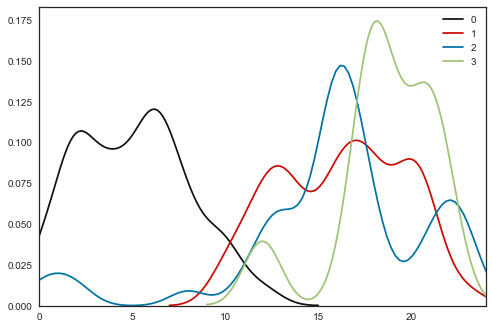

In [2021]:
# show time distributions for these 2 clusters
sns.kdeplot(subselection[subselection.k_clusters == 0].time, bw=1, color='k', label='0')
sns.kdeplot(subselection[subselection.k_clusters == 1].time, bw=1, color='r', label='1')
sns.kdeplot(subselection[subselection.k_clusters == 2].time, bw=1, color='b', label='2')
sns.kdeplot(subselection[subselection.k_clusters == 3].time, bw=1, color='g', label='3')
plt.xlim(0, 24)

In [2022]:
# get ROI
c0_roi = Polygon(get_level(c0, 0))
c1_roi = Polygon(get_level(c1, 0))
c2_roi = Polygon(get_level(c2, 0))
c3_roi = Polygon(get_level(c3, 0))

In [2023]:
# get time window
time0 = subselection[subselection.k_clusters == 0].time.describe()['25%']
time1 = subselection[subselection.k_clusters == 1].time.describe()['25%']
time2 = subselection[subselection.k_clusters == 2].time.describe()['25%']
time3 = subselection[subselection.k_clusters == 3].time.describe()['25%']

time00 = subselection[subselection.k_clusters == 0].time.describe()['75%']
time11 = subselection[subselection.k_clusters == 1].time.describe()['75%']
time22 = subselection[subselection.k_clusters == 2].time.describe()['75%']
time33 = subselection[subselection.k_clusters == 3].time.describe()['75%']

In [2024]:
clusters_k = pd.DataFrame()
clusters_k['geometry'] = [c0_roi, c1_roi, c2_roi, c3_roi]
clusters_k['window_start'] = [time0, time1, time2, time3]
clusters_k['window_end'] = [time00, time11, time22, time33]

In [2025]:
clusters_k

,geometry,window_start,window_end
0,POLYGON ((-73.90404639807407 40.66547800532724...,2.00,7.00
1,POLYGON ((-73.90404639807407 40.67363934520815...,13.00,19.00
2,POLYGON ((-73.85568461223681 40.66926851339413...,13.75,18.00
3,POLYGON ((-73.87962648853384 40.68920447599838...,18.00,20.75


In [2026]:
start_date = '2018-08-01'
end_date = '2018-12-31'

In [2027]:
test_selection = ds[(ds.date > start_date) & (ds.date < end_date) & (ds.precinct == precinct)][['latitude', 'longitude', 'time']].reset_index(drop=True)

In [2028]:
test_selection

,latitude,longitude,time
0,40.685771,-73.880145,4
1,40.660901,-73.895227,2
2,40.687336,-73.875155,14
3,40.669319,-73.900026,20
4,40.665416,-73.900425,8
...,...,...,...
212,40.660492,-73.870509,15
213,40.665261,-73.868921,21
214,40.678472,-73.902756,11
215,40.664249,-73.879765,13


TypeError: make_contour() missing 1 required positional argument: 'levels'

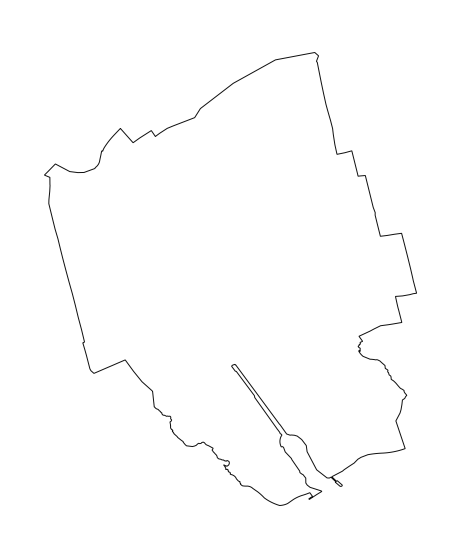

In [2029]:
ax = geoplot.polyplot(clean_map[clean_map.precinct == precinct], figsize=(10, 10), lw= 1, facecolor= 'none', edgecolor='k', alpha=1)

c0 = make_contour(subselection[subselection['k_clusters'] == 0]['longitude'], subselection[subselection['k_clusters'] == 0]['latitude'], clean_map[clean_map.precinct == precinct]['geometry'], colors='k')

c1 = make_contour(subselection[subselection['k_clusters'] == 1]['longitude'], subselection[subselection['k_clusters'] == 1]['latitude'], clean_map[clean_map.precinct == precinct]['geometry'], colors='r')


c2 = make_contour(subselection[subselection['k_clusters'] == 2]['longitude'], subselection[subselection['k_clusters'] == 2]['latitude'], clean_map[clean_map.precinct == precinct]['geometry'], colors='b')


c3 = make_contour(subselection[subselection['k_clusters'] == 3]['longitude'], subselection[subselection['k_clusters'] == 3]['latitude'], clean_map[clean_map.precinct == precinct]['geometry'], colors='g')


ax.scatter(test_selection['longitude'], test_selection['latitude'], c='orange', alpha=.9, s=100)

In [2030]:
points = [Point(x, y) for x, y in list(zip(test_selection.longitude, test_selection.latitude))]
times = list(test_selection.time.values)

In [2031]:
j = 3
yes = 0
for j in range(len(clusters_k)):
    for i in range(len(points)):
        if (points[i].within(clusters_k.iloc[j]['geometry'])) and (clusters_k.iloc[j]['window_start'] < times[i] < clusters_k.iloc[j]['window_end']):
            yes +=1

In [2032]:
yes

63